# 02 - Seismic inversion propagators

This notebook is the second in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic inversion, where we create an gradient (model perturbation associated with a data perturbation) from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling operator and velocity model.

## Inversion requirement

Seismic inversion relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is acquired as described in the first tutorial. In order to simplify this tutorial we will generate synthetic field data by modelling it with the **true velocity model**.

- **Background velocity model**. This is a velocity model that has been obtained by processing and inverting the field data. We will look at this methods in the following tutorial as it relies on the method we are describing here. This velocity model is usually a **smooth version** of the true velocity model.

## Computational setup

In this tutorial, we will introduce the back-propagation operator. This operator simulates the adjoint wave-equation, that is a wave-equation solved in a reversed time order. This time reversal led to the naming of the method we present here called time-reversed in imaging communit. The notion of adjoint in exploration geophysics is fundamental as most of the wave-equation based imaging and inversion methods rely on adjoint based optimization methods.

## Notes on the operators

As we already describe the creation of a forward modelling operator, we will use a thin wrapper function instead. This wrapper is provided by a utility class called `AcousticWaveSolver`, which provides all the necessary operators for seismic modeling, imaging and inversion. The `AcousticWaveSolver` provides a more concise API for common wave propagation operators and caches the the Devito `Operator` objects to avoid unnecessary recompilation. However, any newly introduced operators will be fully described and only used from the wrapper in the next tutorials.

As before we initialize printing and import some utilities. We also raise the Devito log level to avoid excessive logging for repeated operator invocations.

In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log_level'] = 'WARNING'

## Computational considerations

Seismic inversion algorithms are generally very computationally demanding and require a large amount of memory to store the forward wavefield. In order to keep this tutorial as light-weight as possible we are using a very simple
velocity model that requires low temporal and special resolution. For a more realistic model, a second set of preset parameters for a reduced version of the 2D Marmousi data set [1] is provided below in comments. However, this second present is more computationally demanding and requires a slightly more powerful workstation.

In [2]:
# Define true and initial model
from examples.seismic import demo_model, plot_velocity, plot_perturbation

shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbpml=40)

model0 = demo_model('circle-isotropic', vp=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbpml=40)

# Define time discretization according to grid spacing
t0 = 0.
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time
f0 = 0.010 

nshots = 21  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot 

# True and smooth velocity models

First, we create the model data for the "true" model from a given demonstration preset. This model represents the subsurface topology for the purposes of this example and we will later use it to generate our synthetic data readings. We also generate a second model and apply a smoothing filter to it, which represents our initial model for the algorithm. The perturbation between these two models is what we are trying to recover.

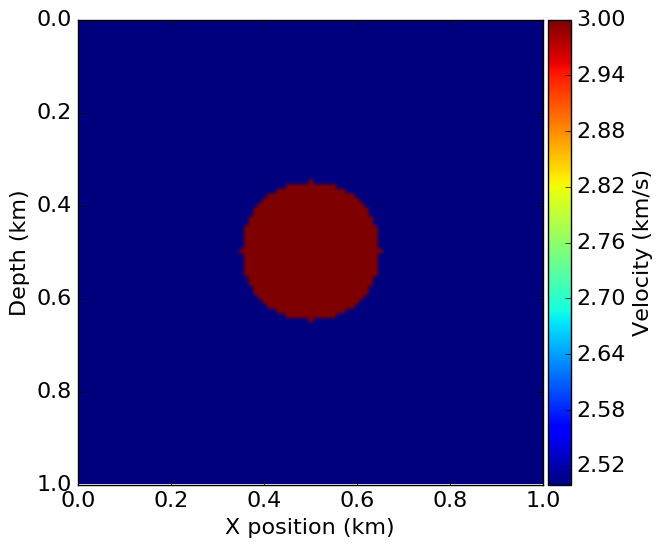

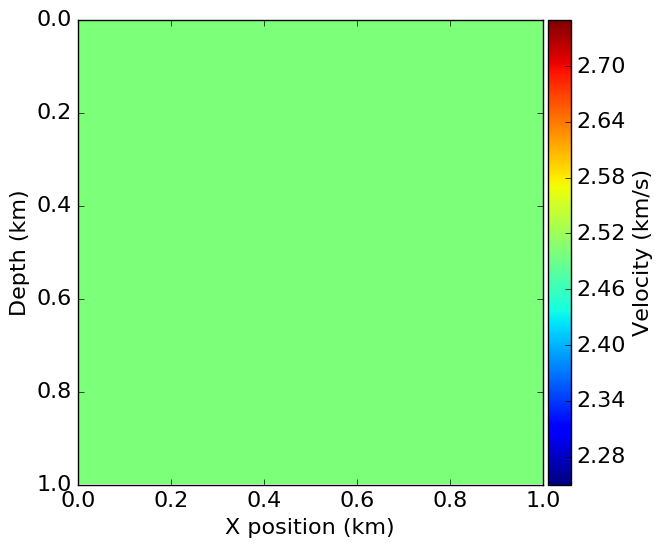

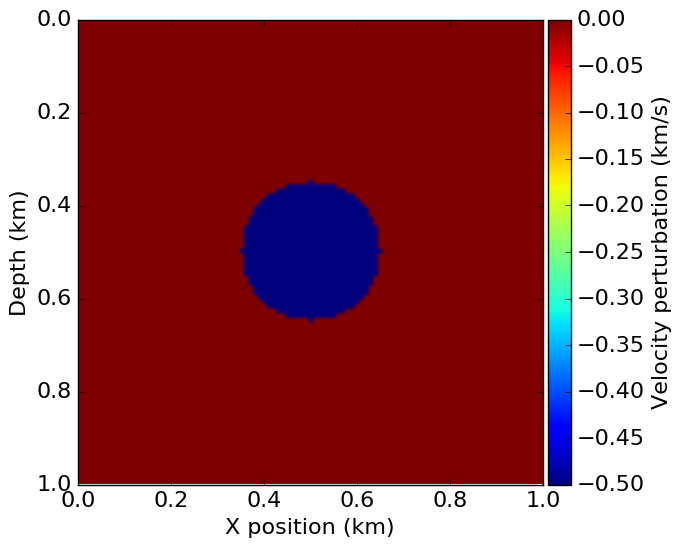

In [3]:
# Define true and intiial model
from examples.seismic import plot_velocity, plot_perturbation
from scipy import ndimage


# Plot the true and initial model and the perturbation between them
plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

## Acquisition geometry

Next we define the positioning and the wave signal of our source and the location of our receivers. To generate the wavelet for our source we require the discretized values of time that we are going to use to model a single "shot",,
which again depends on the grid spacing used in our model. For consistency this initial setup will look exactly as in the previous modelling tutorial, although we will vary the position of our source later on during the actual algorithm.

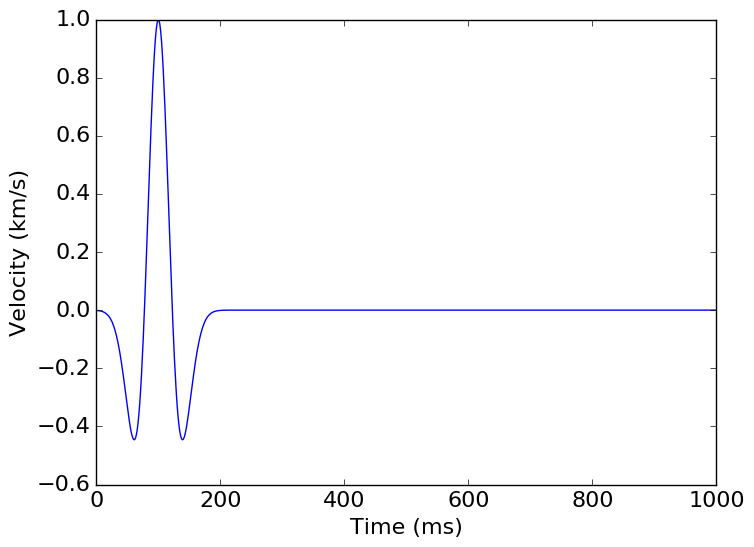

In [4]:
# Define acquisition geometry: source
from examples.seismic import RickerSource

src = RickerSource(name='src', grid=model.grid, f0=f0, time=np.linspace(t0, tn, nt))

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .05
src.coordinates.data[0, -1] = 500.  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

In [5]:
# Define acquisition geometry: receivers
from examples.seismic import Receiver

# Initialize receivers for synthetic and observed data
rec = Receiver(name='rec', npoint=nreceivers, ntime=nt, grid=model.grid)
rec.coordinates.data[:, 0] = 980.
rec.coordinates.data[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)

In [11]:
# For plotting only
src_plot = Receiver(name='src', npoint=21, ntime=nt, grid=model.grid)

# First, position source centrally in all dimensions, then set depth
src_plot.coordinates.data[:, 0] = 20.
src_plot.coordinates.data[:, 1] = np.linspace(0, model.domain_size[0], num=21)

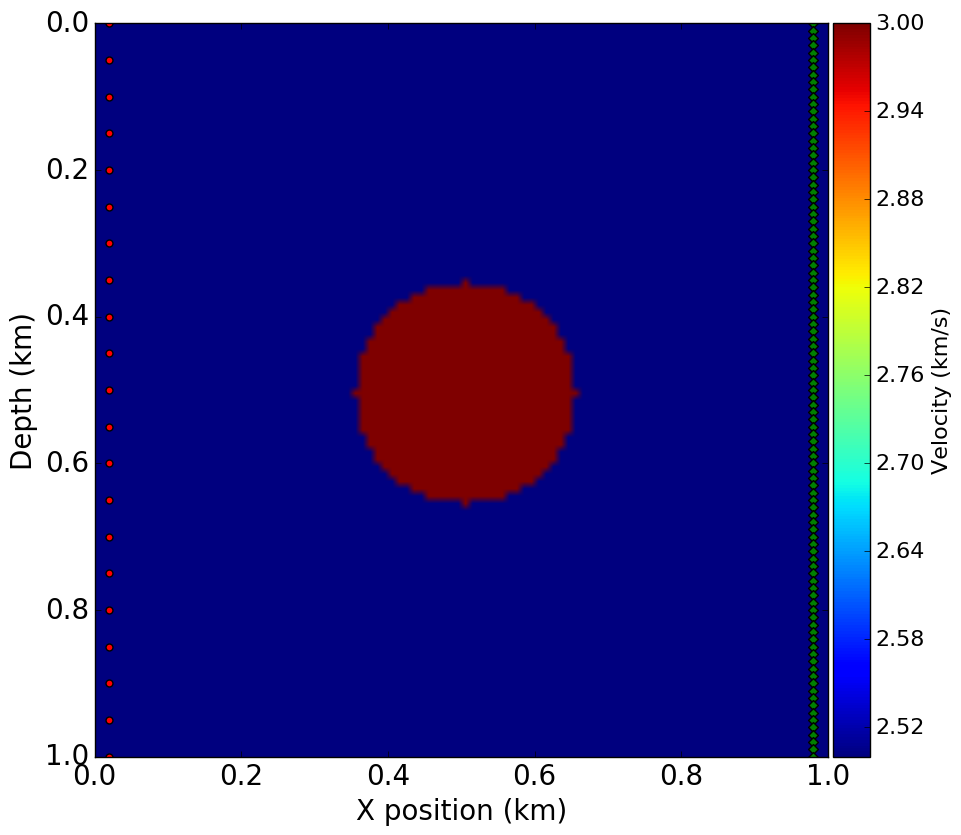

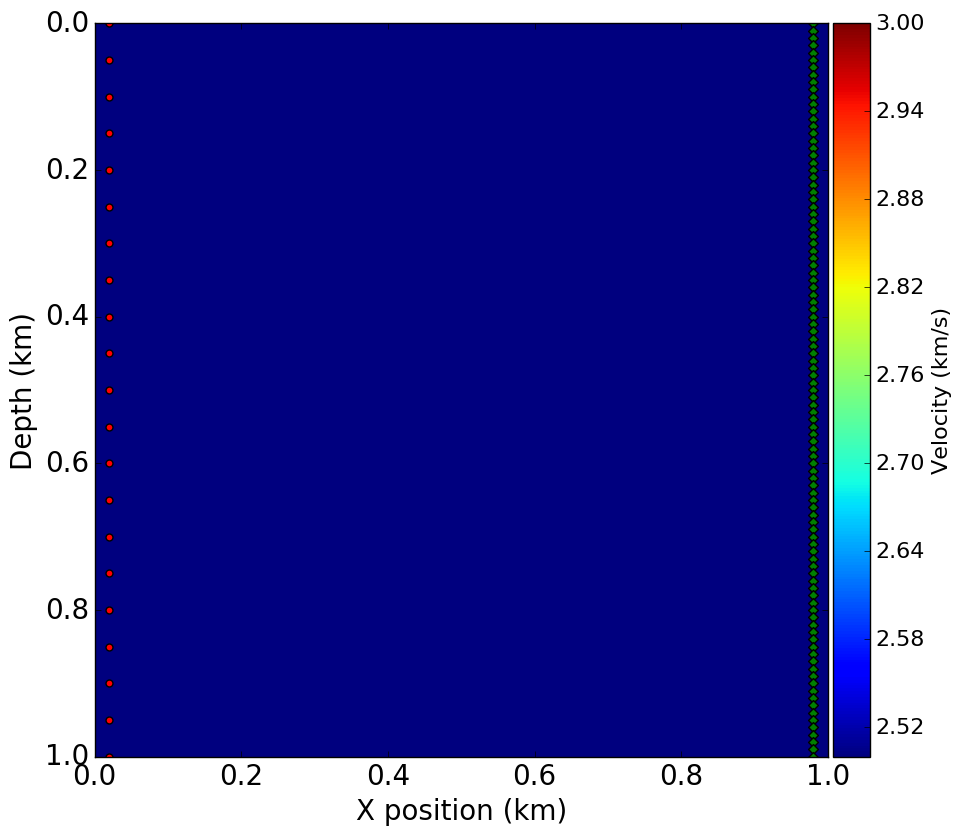

In [12]:

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig1 = plt.figure(figsize=(10, 10))
l = plt.imshow(model.vp, vmin=2.5, vmax=3, cmap=cm.jet, aspect=1,
               extent=[model.origin[0], model.origin[0] + 1e-3*model.shape[0] * model.spacing[0],
                       model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
plt.scatter(1e-3*rec.coordinates.data[:, 0], 1e-3*rec.coordinates.data[:, 1],
                    s=25, c='green', marker='D')
plt.scatter(1e-3*src_plot.coordinates.data[:, 0], 1e-3*src_plot.coordinates.data[:, 1],
                    s=25, c='red', marker='o')
# Ensure axis limits
plt.xlim(model.origin[0], model.origin[0] + 1e-3*model.domain_size[0])
plt.ylim(model.origin[1] + 1e-3*model.domain_size[1], model.origin[1])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(l, cax=cax)
cbar.set_label('Velocity (km/s)')
plt.savefig("../Figures/camembert_true.pdf")
plt.show()

fig1 = plt.figure(figsize=(10, 10))
l = plt.imshow(model0.vp, vmin=2.5, vmax=3, cmap=cm.jet, aspect=1,
               extent=[model.origin[0], model.origin[0] + 1e-3*(model.shape[0]-1) * model.spacing[0],
                       model.origin[1] + 1e-3*(model.shape[1]-1) * model.spacing[1], model.origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
plt.scatter(1e-3*rec.coordinates.data[:, 0], 1e-3*rec.coordinates.data[:, 1],
                    s=25, c='green', marker='D')
plt.scatter(1e-3*src_plot.coordinates.data[:, 0], 1e-3*src_plot.coordinates.data[:, 1],
                    s=25, c='red', marker='o')
# Ensure axis limits
plt.xlim(model.origin[0], model.origin[0] + 1e-3*model.domain_size[0])
plt.ylim(model.origin[1] + 1e-3*model.domain_size[1], model.origin[1])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(l, cax=cax)
cbar.set_label('Velocity (km/s)')
plt.savefig("../Figures/camembert_init.pdf")
plt.show()

# True and smooth data

We can now generate the shot record (receiver readings) corresponding to our true and initial models. The difference between these two records will be the basis of the inversion procedure.

For this purpose we will use the same forward modelling operator that was introduced in the previous tutorial, provided by the `WaveSolver` utility class. This object instantiates a set of pre-defined operators according to an initial definition of the acquisition geometry, consisting of source and receiver symbols. The solver objects caches the individual operators and provides a slightly more high-level API that allows us to invoke the modelling modelling operators from the initial tutorial in a single line. In the following cells we use this to generate shot data by only specifying the respective model symbol `m` to use, and the solver will create and return a new `Receiver` object the represents the readings at the previously defined receiver coordinates.  

In [13]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, src, rec, space_order=4)
true_d , _, _ = solver.forward(src=src, m=model.m)

In [14]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(src=src, m=model0.m)

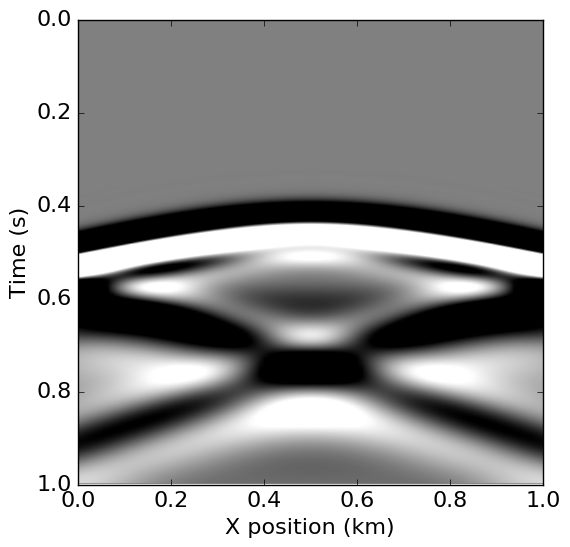

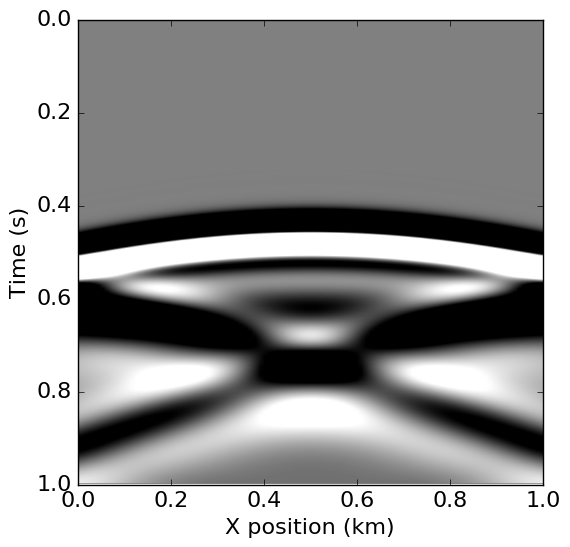

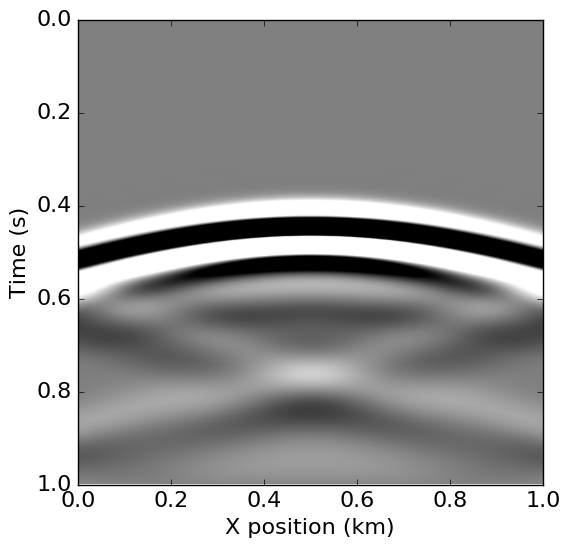

In [15]:
# Plot shot record for true and smooth velocity model and the difference
from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, model, t0, tn, colorbar=False)
plot_shotrecord(smooth_d.data, model, t0, tn, colorbar=False)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn, colorbar=False)

# Inversion with back-propagation

As we explained in the introduction of this tutorial, this method is based on back-propagation. 

## Adjoint wave equation

If we go back to the modelling part, we can rewrite the simulation as a linear system solve:

\begin{equation}
\mathbf{A}(\mathbf{m}) \mathbf{u} = \mathbf{q}
\end{equation}

where $\mathbf{m}$ is the discretized square slowness, $\mathbf{q}$ is the discretized source and $\mathbf{A}(\mathbf{m})$ is the discretized wave-equation. The discretized wave-equation matricial representation is a lower triangular matrix that can be solve with forward substitution. The pointwise writing or the forward substitution leads to the time-stepping stencil.

On a small problem one could form the matrix explicitly and transpose it to obtain the adjoint discrete wave-equation:

\begin{equation}
\mathbf{A}(\mathbf{m})^T \mathbf{v} = \delta \mathbf{d}
\end{equation}

where $\mathbf{v}$ is the discrete **adjoint wavefield** and  $\delta \mathbf{d}$ is the data residual defined as the difference between the field/observed data and the synthetic data $\mathbf{d}_s = \mathbf{P}_r \mathbf{u}$. In our case we derive the discrete adjoint wave-equation from the discrete forward wave-equation to get its stencil. 

## Gradient

Wave-equation based Jacobian relies on the linearization of the forward modelling operator provides data perturbation according to a model perturbation. Its adjoint is the gradient update for a data pertirbation.

- If the background velocity model is cinematically correct, the forward wavefield $\mathbf{u}$ and the adjoint wavefield $\mathbf{v}$ meet at the reflectors position at zero time offset. 

The sum over time of the zero time-offset correlation of these two fields then creates amodel update. Mathematically this leads to the simple cross-correlation gradient:

\begin{equation}
  \text{gradient} = \sum_{t=1}^{n_t} \mathbf{u}[t] \mathbf{v}[t]
\end{equation}

In the following tutorials we will describe a more advanced usage of the gradient that produces shaper and more accurate results.

## Operator

We will now define the gradient operator that computes the adjoint wavefield $\mathbf{v}$ and correlates it with the forward wavefield $\mathbf{u}$. This operator essentially consist of three components:
* Stencil update of the adjoint wavefield `v`
* Injection of the data residual at the adjoint source (forward receiver) location
* Correlation of `u` and `v` to compute the gradient contribution at each timestep

In [16]:
# Define gradient operator
from devito import Backward, Operator, TimeFunction, Eq
from examples.seismic import PointSource

from sympy import solve

def GradientOperator(model, grad, rec, save=False):
    # Define the wavefield with the size of the model and the time dimension
    # In practice, v does not need to be saved, we however keep it for plotting
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4,
                     save=save, time_dim=nt)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=4,
                     save=True, time_dim=nt)
    
    # Define the wave equation, but with a negated damping term
    eqn = model.m * v.dt2 - v.laplace - model.damp * v.dt

    # Use SymPy to rearranged the equation into a stencil expression
    stencil = Eq(v.backward, solve(eqn, v.backward)[0])
    
    # Define residual injection at the location of the forward receivers
    dt = model.critical_dt
    residual = PointSource(name='residual', ntime=nt, coordinates=rec.coordinates.data,
                          grid=model.grid)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m, offset=model.nbpml)

    # Correlate u and v for the current time step and add it to the gradient
    grad_update = Eq(grad, grad - u * v.dt2)

    return Operator([stencil] + res_term + [grad_update],
                    time_axis=Backward)

# Smooth version of the true model as initial model

In [17]:
from devito import Function

grad = Function(name='grad', grid=model.grid)
op_grad = GradientOperator(model, grad, rec, save=True)
# Generate synthetic data from true model
true_d, _, _ = solver.forward(src=src, m=model.m)

# Compute smooth data and full forward wavefield u0
smooth_d, u0, _ = solver.forward(src=src, m=model0.m, save=True)

# Compute gradient from the data residual  
v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4,
                 save=True, time_dim=nt)
op_grad(u=u0, v=v, m=model0.m, residual=smooth_d.data - true_d.data, dt=model.critical_dt)




In [ ]:
# Adjoint wavefield movie

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(np.transpose(v.data[0,40:-40,40:-40]), animated=True, vmin=-1e1, vmax=1e1, cmap=cm.RdGy, aspect=1,
                 extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                         model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
im2 = plt.imshow(np.transpose(model0.vp), vmin=1.5, vmax=4.5, cmap=cm.jet, aspect=1,
                 extent=[model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
                         model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]], alpha=.4)
def updatefig(i):
    im.set_array(np.transpose(v.data[-i,40:-40,40:-40]))
    im2.set_array(np.transpose(model0.vp))
    return im, im2

ani = animation.FuncAnimation(fig, updatefig, frames=np.linspace(1, nt, nt, dtype=np.int64), blit=True, interval=100)
# plt.close(ani._fig)
# HTML(ani.to_html5_video())


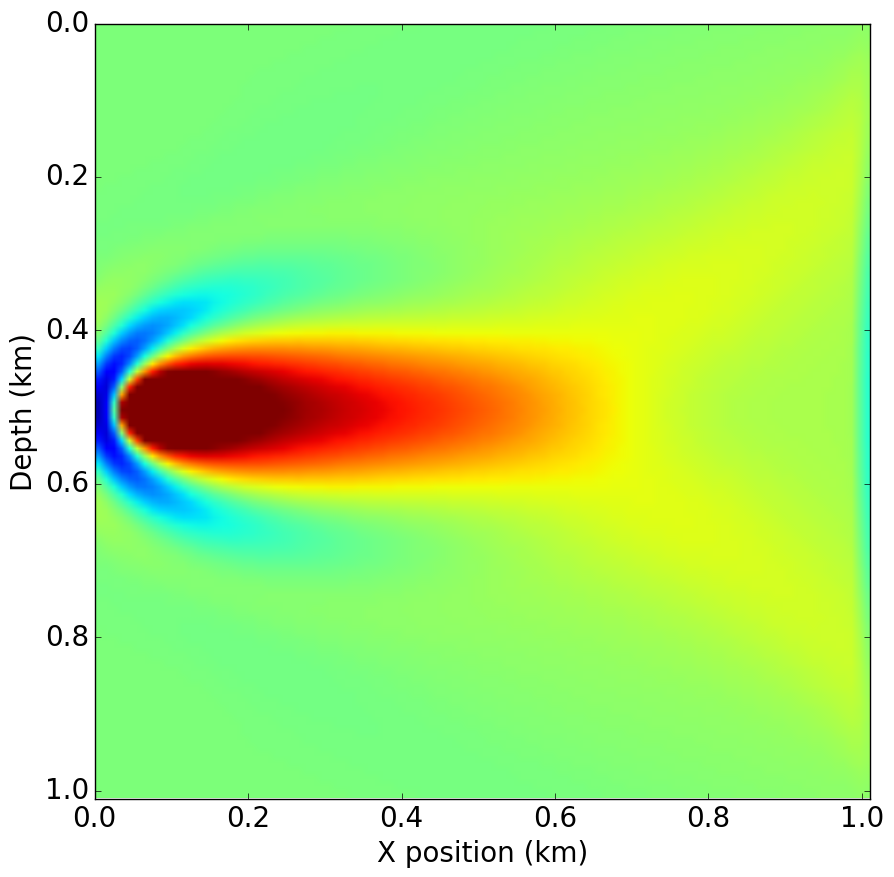

In [18]:
from examples.seismic import plot_image
# Plot the FWI gradient
import matplotlib.pyplot as plt
from matplotlib import cm

fig1 = plt.figure(figsize=(10,10))
l = plt.imshow(np.transpose(grad.data[40:-40, 40:-40]), vmin=-1e3, vmax=1e3, cmap=cm.jet, aspect=1,
               extent=[model.origin[0], model.origin[0] + 1e-3*model.shape[0] * model.spacing[0],
                       model.origin[1] + 1e-3*model.shape[1] * model.spacing[1], model.origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
plt.savefig("../Figures/banana.pdf")

## Implementation of the gradient loop

As we just explained, the forward wave-equation is solved forward in time while the adjoint wave-equation is solved in a reversed time order. Therefore, the correlation of these two fields over time requires to store one of the two fields. The computational procedure follows:

- Simulate the forward wave-equation with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the gradient contribution at each time step. 

This procedure is applied to multiple source positions (shots) and summed to obtain the full model update of the subsurface. We can first visualize the varying locations of the sources that we will use. 

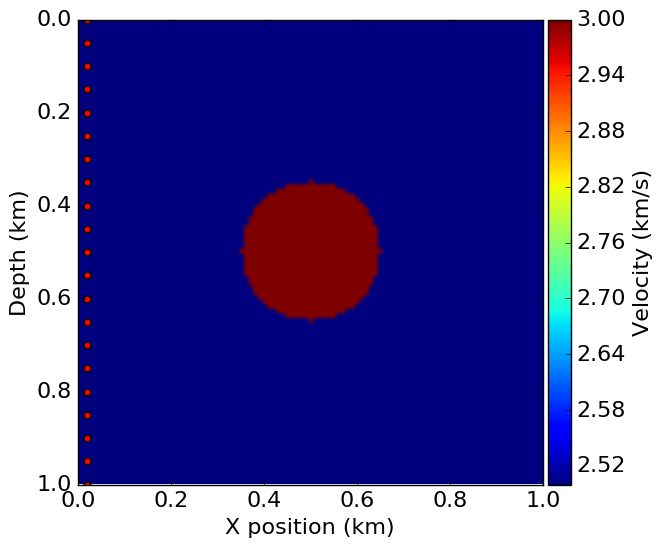

In [19]:
# Prepare the varying source locations sources
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 20.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

In [21]:
# Run gradient loop over shots

# Create gradient symbol and instantiate the previously defined gradient operator
grad = Function(name='grad', grid=model.grid, dtype=model.m.dtype)
op_grad2 = GradientOperator(model, grad, rec)
u0 = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=4,
              save=True, time_dim=nt)
residual = Receiver(name='residual', ntime=nt, coordinates=rec.coordinates.data, grid=model.grid)
for i in range(nshots):
    print('Source %d out of %d' % (i+1, nshots))
    
    # Update source location
    src.coordinates.data[0, :] = source_locations[i, :]

    # Generate synthetic data from true model
    true_d, _, _ = solver.forward(src=src, m=model.m)
    
    # Compute smooth data and full forward wavefield u0
    smooth_d, _, _ = solver.forward(src=src, m=model0.m, u=u0, save=True)
    
    # Compute gradient from the data residual  
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)
    residual.data[:] = smooth_d.data[:] - true_d.data[:]
    op_grad2(u=u0, v=v, m=model0.m, residual=residual, grad=grad, dt=model.critical_dt)

Explicit time dimension size (time_dim) found for TimeFunction symbol v, despite 
using a stepping time dimension (save=False). This value will be ignored!


Source 1 out of 21
Source 2 out of 21
Source 3 out of 21
Source 4 out of 21
Source 5 out of 21
Source 6 out of 21
Source 7 out of 21
Source 8 out of 21
Source 9 out of 21
Source 10 out of 21
Source 11 out of 21
Source 12 out of 21
Source 13 out of 21
Source 14 out of 21
Source 15 out of 21
Source 16 out of 21
Source 17 out of 21
Source 18 out of 21
Source 19 out of 21
Source 20 out of 21
Source 21 out of 21


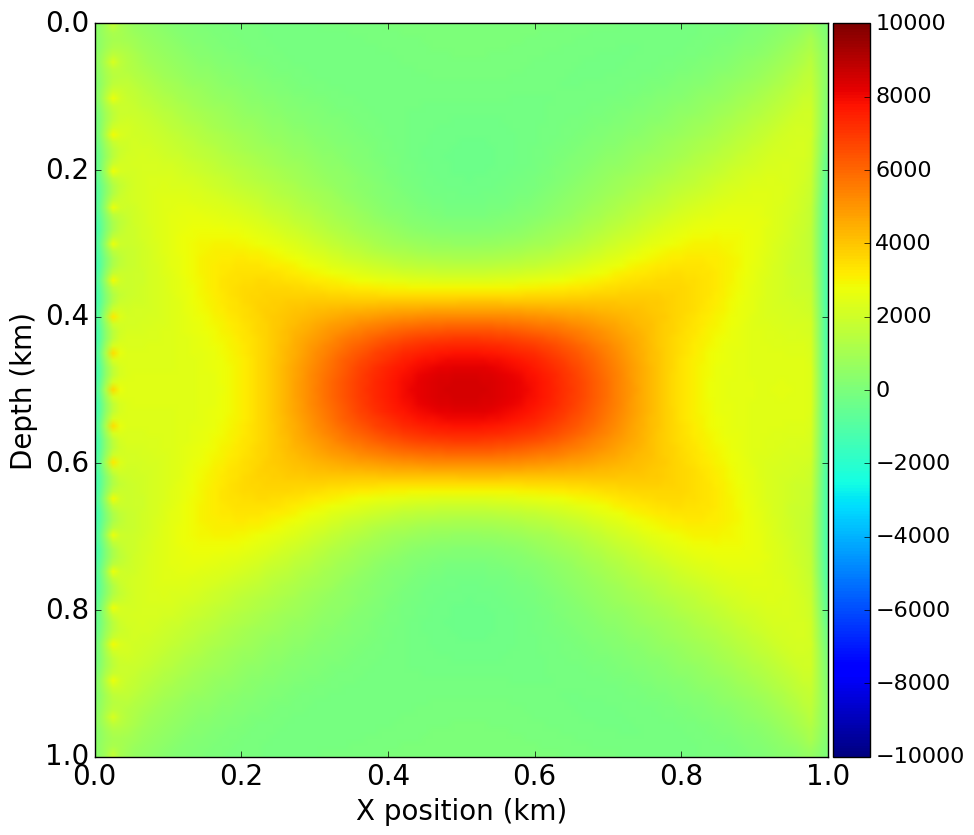

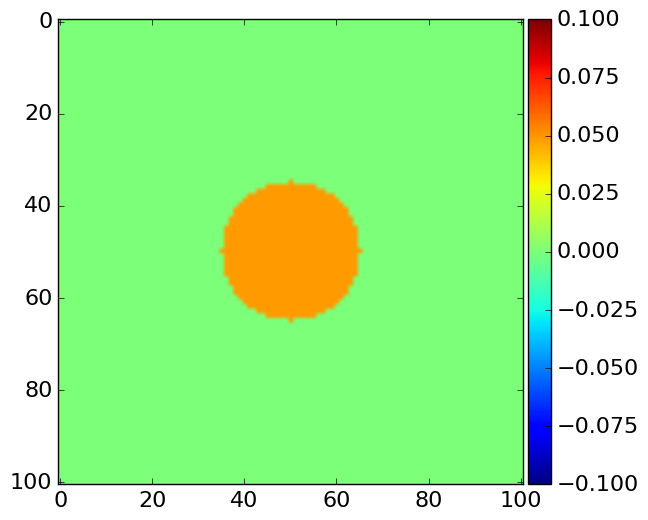

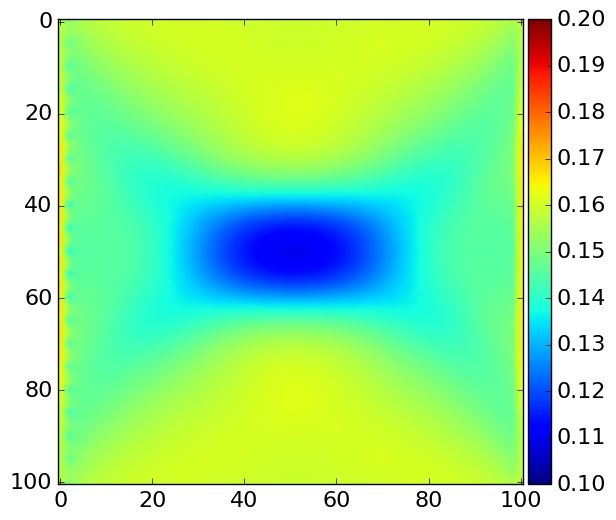

In [24]:
# Plot FWI gradient and model update
from examples.seismic import plot_image

# Plot the FWI gradient
# Plot the FWI gradient
import matplotlib.pyplot as plt
from matplotlib import cm

fig1 = plt.figure(figsize=(10,10))
l = plt.imshow(np.transpose(grad.data[40:-40, 40:-40]), vmin=-1e4, vmax=1e4, cmap=cm.jet, aspect=1,
               extent=[model.origin[0], model.origin[0] + 1e-3*(model.shape[0]-1) * model.spacing[0],
                       model.origin[1] + 1e-3*(model.shape[1]-1) * model.spacing[1], model.origin[1]])
plt.xlabel('X position (km)',  fontsize=20)
plt.ylabel('Depth (km)',  fontsize=20)
plt.tick_params(labelsize=20)
# Ensure axis limits
plt.xlim(model.origin[0], model.origin[0] + 1e-3*model.domain_size[0])
plt.ylim(model.origin[1] + 1e-3*model.domain_size[1], model.origin[1])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(l, cax=cax)
plt.savefig("../Figures/simplegrad.pdf")
plt.show()

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.m.data[40:-40, 40:-40] - model.m.data[40:-40, 40:-40], vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .05 / np.max(grad.data)
plot_image(model0.m.data[40:-40, 40:-40] - alpha*grad.data[40:-40, 40:-40], vmin=.1, vmax=.2, cmap="jet")

# FWI

We no use the preimplemented Devito operator for simplicity and setup the FWI objective that can  be used in inversion. The bojective is a function that given a velocity model and data, outputs the objective function value and the gradient.

In [ ]:
# Create FWI gradient kernel 
from devito import DenseData, clear_cache

def fwi_gradient(m_in):
    # Important: We force previous wavefields to be destroyed,
    # so that we may reuse the memory.
    clear_cache()
    
    # Create symbols to hold the gradient and residual
    grad = DenseData(name="grad", shape=model.shape_domain, dtype=model.dtype)
    residual = Receiver(name='rec', ntime=nt, coordinates=rec.coordinates.data)
    u0 = TimeData(name='u', shape=model.shape_domain, time_order=2, space_order=4,
                  save=True, time_dim=nt)
    objective = 0.
    
    for i in range(nshots):
        # Update source location
        src.coordinates.data[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        # In practice, this line would be replace by some I/O, shot = load(shot)
        true_d, _, _ = solver.forward(src=src, m=model.m)
        
        # Compute smooth data and full forward wavefield u0
        smooth_d, _, _ = solver.forward(src=src, m=m_in, u=u0, save=True)
        
        # Compute gradient from data residual and update objective function 
        residual.data[:] = smooth_d.data[:] - true_d.data[:]
        objective += .5*np.linalg.norm(residual.data.reshape(-1))**2
        solver.gradient(rec=residual, u=u0, m=m_in, grad=grad)
    
    grad.data[0:25,:] = 0.
    grad.data[-25:,:] = 0.
    return objective, grad.data

Having defined our FWI gradient procedure we can compute the initial iteration from our starting model. This allows us to visualize the gradient alongside the model perturbation and the effect of the gradient update on the model.

In [ ]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.m)
print('Objective value is %f ' % ff)

In [ ]:
# Plot FWI gradient and model update
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(update[40:-40, 40:-40], vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.m.data[40:-40, 40:-40] - model.m.data[40:-40, 40:-40], vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .05 / np.max(update)
plot_image(model0.m.data[40:-40, 40:-40] - alpha*update[40:-40, 40:-40], vmin=.1, vmax=.2, cmap="jet")

In [ ]:
# Create bounds constraint
def bound_constr(m):
    m[m<.1] = .08 # Maximum accepted velocity is 3.5 km/sec (true is 3 km/sec)
    m[m>.2] = .25 # Minimum accepted velocity is 2 km/sec (true is 2.5 km/sec)
    return m

In [ ]:
# Run FWI with gradient descent
fwi_iterations = 8
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.m)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guaranty functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .005 / np.max(direction)
    
    # Update the model estimate and inforce minimum/maximum values
    model0.m.data[:] = bound_constr(model0.m.data - alpha * direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

In [ ]:
# Plot inverted velocity model

# First, update velocity from computed square slowness
nbpml = model.nbpml
model0.vp = np.sqrt(1. / model0.m.data[nbpml:-nbpml, nbpml:-nbpml])

plot_velocity(model0)

In [ ]:
# Plot objective function decrease
import matplotlib.pyplot as plt

plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

## References

[1] _Versteeg, R.J. & Grau, G. (eds.) (1991): The Marmousi experience. Proc. EAGE workshop on Practical Aspects of Seismic Data Inversion (Copenhagen, 1990), Eur. Assoc. Explor. Geophysicists, Zeist._